## EDA1 - Exploratory Data Analysis 1
Goals:
* load data into dataframe
* use matplotlib to show line charts over various date ranges
* Annotate chart with interesting time periods
* Deep dive on some weight loss attempts

In [151]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns

In [129]:
weight_csv_file = Path.cwd() / '..' / 'data' / 'weight.csv'
df = pd.read_csv(weight_csv_file)
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.sort_index()
df.head()

,Weight (lb),Fat mass (lb),Bone mass (lb),Muscle mass (lb),Hydration (lb),Comments
Date,,,,,,
2013-08-28 19:57:10,180.8,NaN,NaN,NaN,NaN,NaN
2013-09-02 18:53:13,183.9,46.0,NaN,NaN,NaN,NaN
2013-09-02 18:53:14,180.8,NaN,NaN,NaN,NaN,NaN
2013-09-02 18:54:28,180.8,NaN,NaN,NaN,NaN,NaN
2013-09-02 21:36:20,186.2,47.5,NaN,NaN,NaN,NaN


In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2221 entries, 2013-08-28 19:57:10 to 2025-03-30 12:09:03
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Weight (lb)       2221 non-null   float64
 1   Fat mass (lb)     2049 non-null   float64
 2   Bone mass (lb)    740 non-null    float64
 3   Muscle mass (lb)  740 non-null    float64
 4   Hydration (lb)    740 non-null    float64
 5   Comments          0 non-null      float64
dtypes: float64(6)
memory usage: 121.5 KB


<Axes: xlabel='Date'>

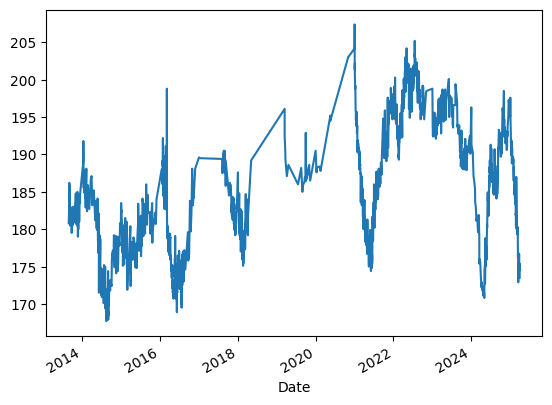

In [131]:
df['Weight (lb)'].plot()

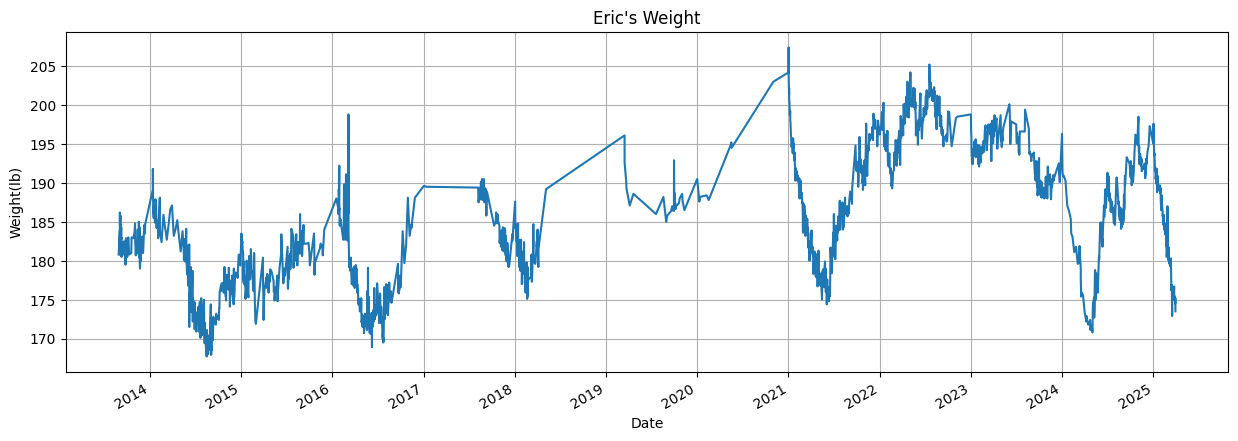

In [132]:
fig, ax = plt.subplots(figsize=(15,5))
df['Weight (lb)'].plot(ax=ax)

# Format ticks every year
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # every 1 year
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlabel('Date')
plt.ylabel('Weight(lb)')
plt.title("Eric's Weight")
plt.grid(True)
plt.show()

## Some observations:
### Multiple weight loss attempts
It looks like weight loss has been attempted multiple times
* Usually (always?) it fails and weight rebounds to original or higher weight
* Frequently weight loss starts on Jan 1st.
  * It would be interesting to see stats on how long the attempts last
Examples (do deep dives on these):
* **2014** *possibly longest run*
* **2016** *pretty wild*
* **2017** *towards end*
* **2018** *short lived*
* **2021** *good run - then d'oh!*
* **2023** *mid year, maybe*
* **2024** *deja vu to 2021*
* **2025** *so far so good*

(At least) 8 attempts.

### Recording is spotty
Some periods, especially 2017-2021 have low data rates.  This is probably due to giving up.

### Next Steps
Focus on 2015.
* Expand plot to view 2015 only
* Add annotations showing vertical bars at high and low points
* Smooth graph (resample by week?) to show trends

### Idea
* Side-by-side of 2024 and 2025 - measuring how close 2025 weight is to lowpoint of 2024

## Yearly Deep Dives

In [138]:
def graph_year(year):
    df_year = df.loc[f'{year-1}-12':f'{year}-12'].copy()
    df_year['Smoothed'] = df_year['Weight (lb)'].rolling(window=7, center=True).mean()

    min_weight = df_year['Weight (lb)'].min()
    min_date = df_year['Weight (lb)'].idxmin()

    # ensure that max_date < min_date
    df_to_min = df_year.loc[:min_date]
    max_weight = df_to_min['Weight (lb)'].max()
    max_date = df_to_min['Weight (lb)'].idxmax()

    drop = (max_weight - min_weight).round(1)

    fig, ax = plt.subplots(figsize=(15,5))
    df_year['Smoothed'].plot(ax=ax, label='Smoothed', color='orange')
    df_year['Weight (lb)'].plot(ax=ax, alpha=0.1, label='Original')
    
    # Format ticks every year
    ax.xaxis.set_major_locator(mdates.MonthLocator()) 
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
    # Max & Min lines
    ax.axhline(max_weight, color='red', linestyle='--', alpha=0.7, label='Max')
    ax.axhline(min_weight, color='green', linestyle='--', alpha=0.7, label='Min')
    
    # Annotations
    ax.annotate(f'{max_date.date()}\nMax: {max_weight:.1f} lb',
                xy=(max_date, max_weight),
                xytext=(max_date, max_weight + 3),
                arrowprops=dict(facecolor='red', shrink=0.02),
                ha='center', color='red')

    ax.annotate(f'{min_date.date()}\nMin: {min_weight:.1f} lb',
                xy=(min_date, min_weight),
                xytext=(min_date, min_weight - 7),
                arrowprops=dict(facecolor='green', shrink=0.02),
                ha='center', color='red')
    
    # Vertical line
    x_val = max_date if max_date < min_date else min_date
    ax.vlines(x=x_val,
              ymin=min(min_weight, max_weight),
              ymax=max(min_weight, max_weight),
              color='purple',
              linestyle=':',
              linewidth=2,
              label='Weight Drop')
    
    # Text label for drop
    drop_amount = abs(max_weight - min_weight)
    ax.text(x_val, (max_weight + min_weight) / 2,
            f'-{drop_amount:.1f} lb',
            color='purple',
            ha='left',
            va='center',
            fontsize=10,
            backgroundcolor='white')
    
    # axis labels
    plt.xlabel('Date')
    plt.ylabel('Weight(lb)')
    plt.title(f"Eric's Weight in {year}")
    plt.grid(True)

    # standardize x-axis, used for years with less data
    ax.set_xlim(pd.Timestamp(f'{year-1}-12-15'), pd.Timestamp(f'{year+1}-01-15'))
    # standardize y-axis
    ax.set_ylim(160, 210)
    
    plt.show()

    # gather some stats for this year
    return {'year': year, 'drop': max_weight - min_weight, 'duration': min_date - max_date}

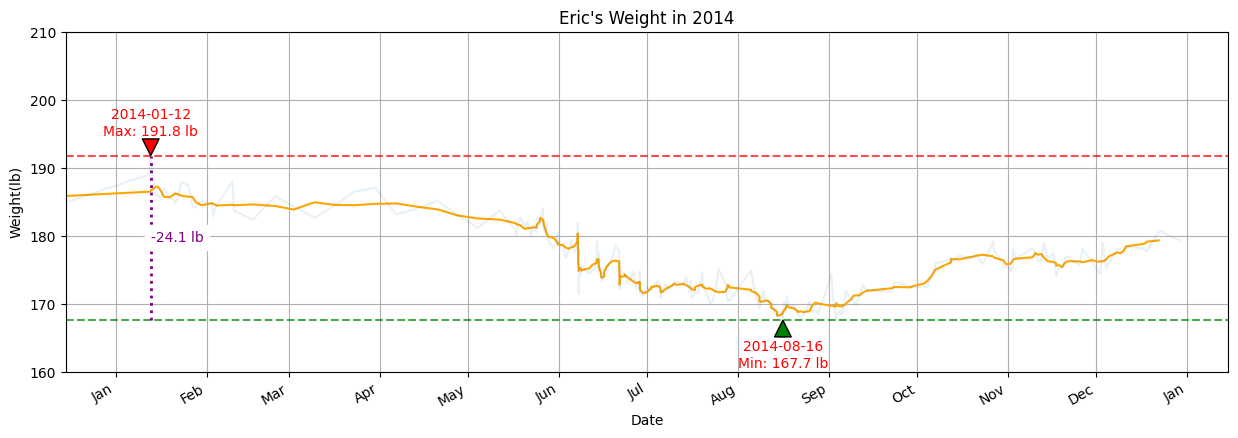

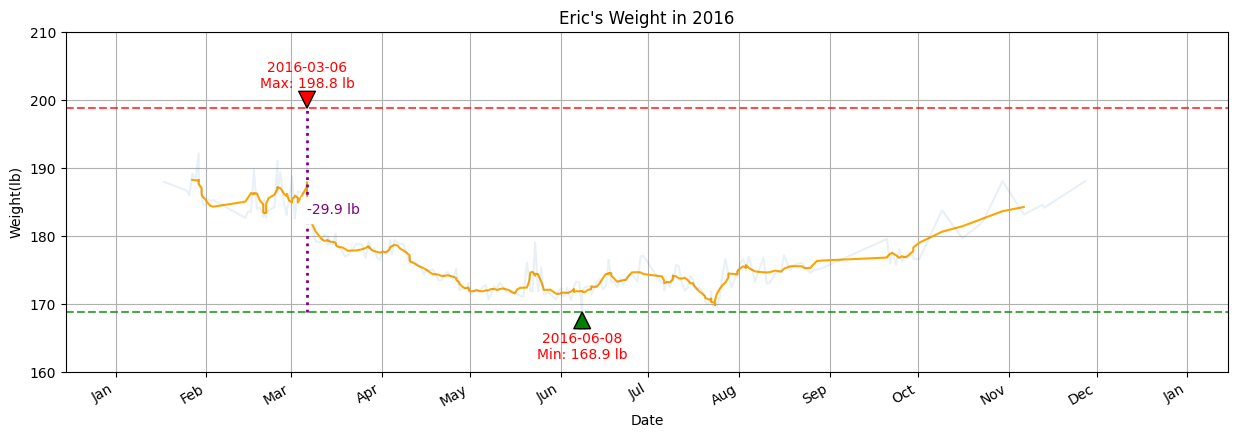

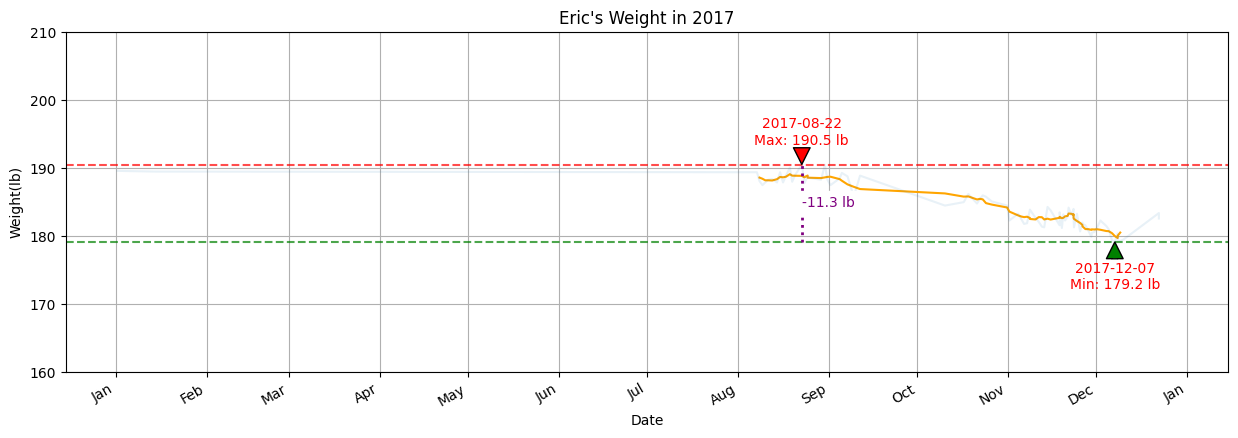

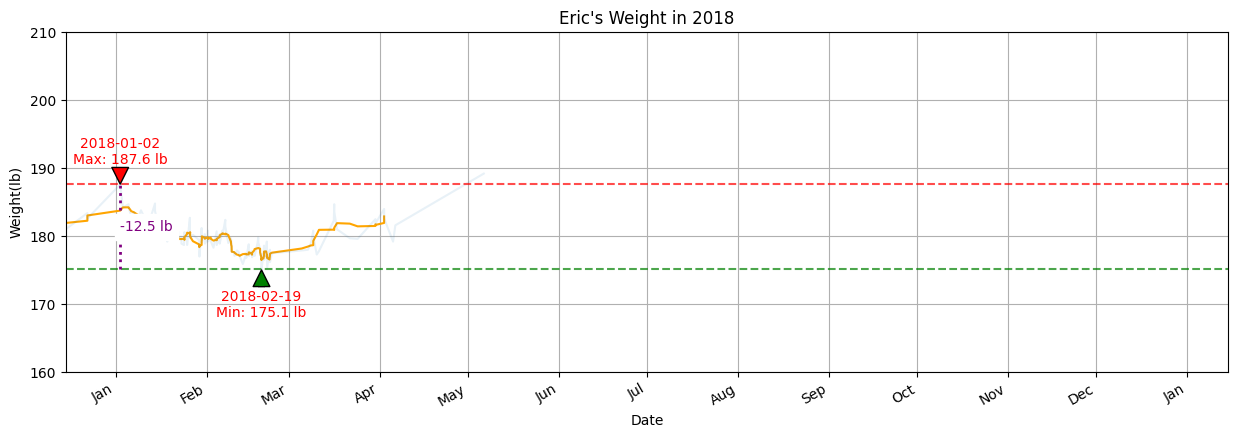

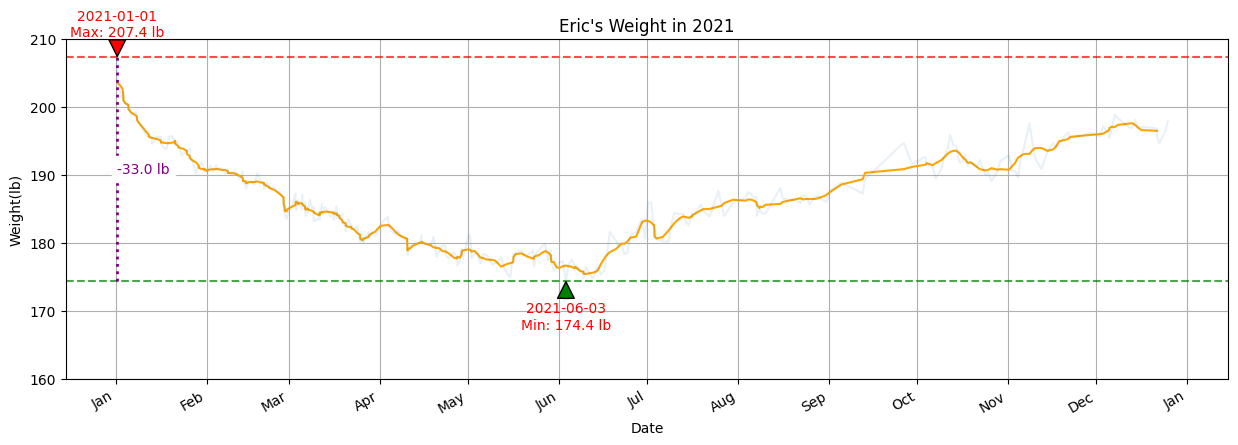

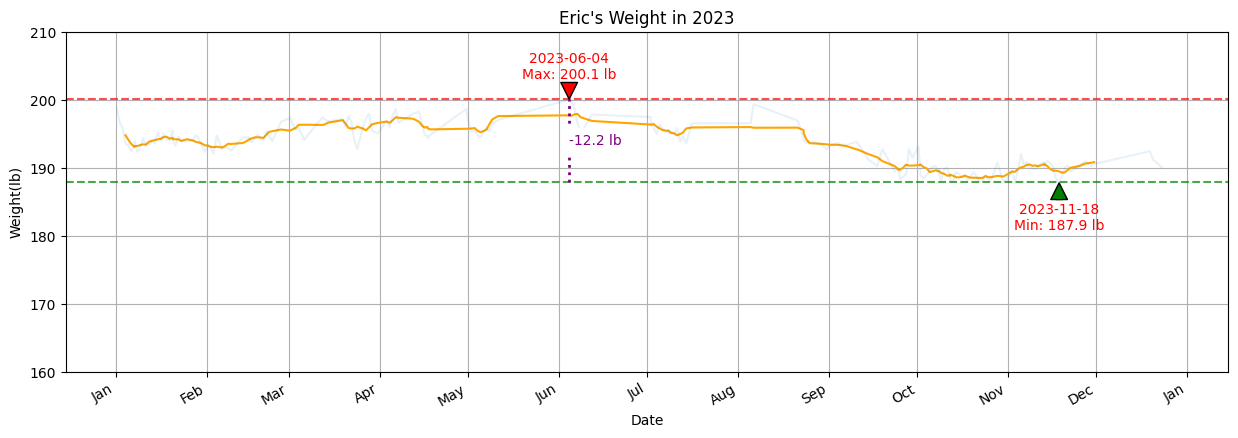

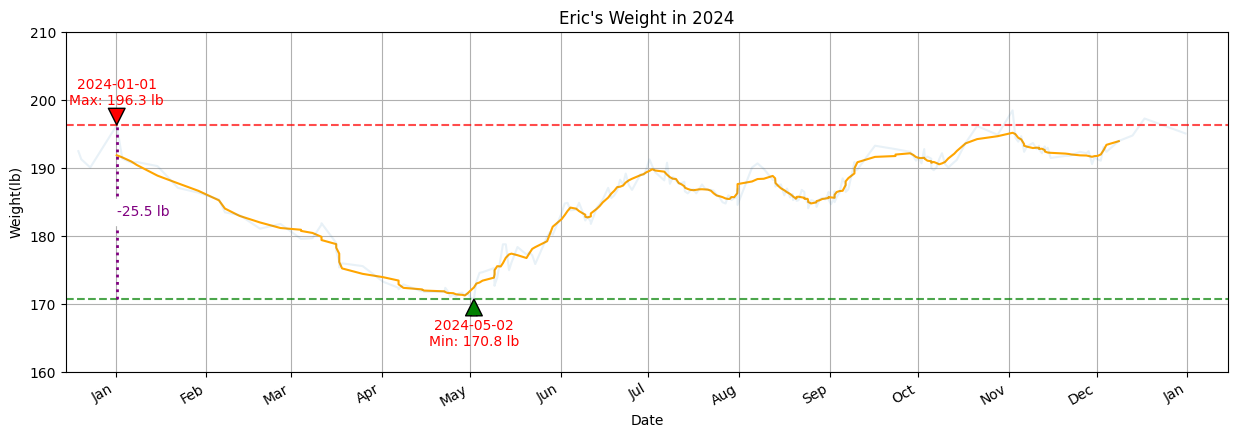

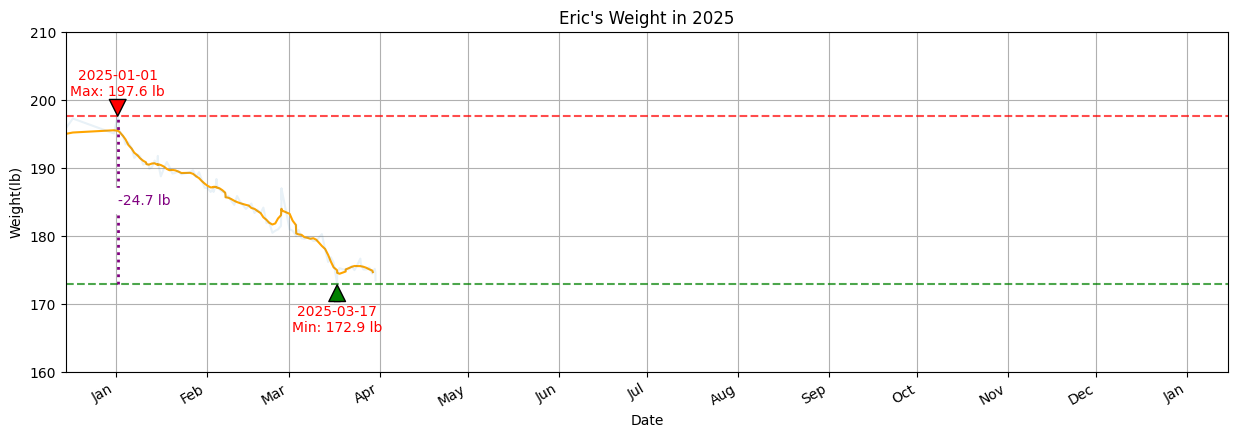

In [139]:
summary_records = [graph_year(year) for year in [2014, 2016, 2017, 2018, 2021, 2023, 2024, 2025]]
summary_df = pd.DataFrame(summary_records)

In [140]:
summary_df

,year,drop,duration
0,2014,24.1,215 days 08:18:07
1,2016,29.9,93 days 23:19:56
2,2017,11.3,106 days 15:01:11
3,2018,12.5,48 days 03:23:47
4,2021,33.0,152 days 19:48:42
5,2023,12.2,166 days 21:50:58
6,2024,25.5,121 days 23:41:56
7,2025,24.7,74 days 18:09:10


In [141]:
summary_df[['drop', 'duration']].describe()

,drop,duration
count,8.00000,8
mean,21.65000,122 days 13:41:43.375000
std,8.51184,53 days 23:12:18.523738229
min,11.30000,48 days 03:23:47
25%,12.42500,89 days 04:02:14.500000
50%,24.40000,114 days 07:21:33.500000
75%,26.60000,156 days 08:19:16
max,33.00000,215 days 08:18:07


### Histogram and boxplot of weight

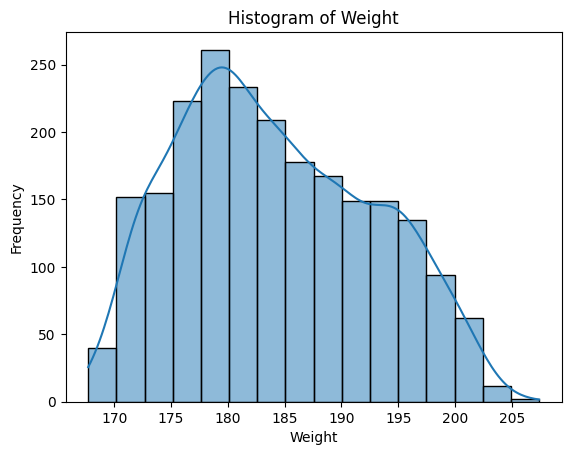

In [148]:
sns.histplot(df['Weight (lb)'], bins=16, kde=True)
plt.title('Histogram of Weight')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

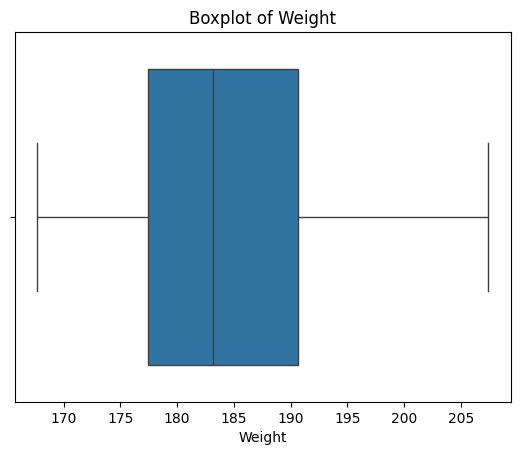

In [150]:
sns.boxplot(x=df['Weight (lb)'])
plt.title('Boxplot of Weight')
plt.xlabel('Weight')
plt.show()

In [175]:
def plot_current_weight(current_weight):
    percentile = np.mean(df['Weight (lb)'] <= current_weight) * 100

    # Boxplot
    plt.figure(figsize=(8,4))
    plt.boxplot(df['Weight (lb)'], vert=False)
    plt.title('Boxplot of Weight with Current Weight Highlighted')
    plt.xlabel('Weight')

    # Plot current_weigh with a red dot
    plt.scatter(y=1, x=current_weight, color='red', zorder=3)
    plt.text(current_weight, 1.1, f'Current Weight ({current_weight} lbs)\n{percentile:.1f} percentile', color='red', fontsize=9)
    plt.tight_layout()

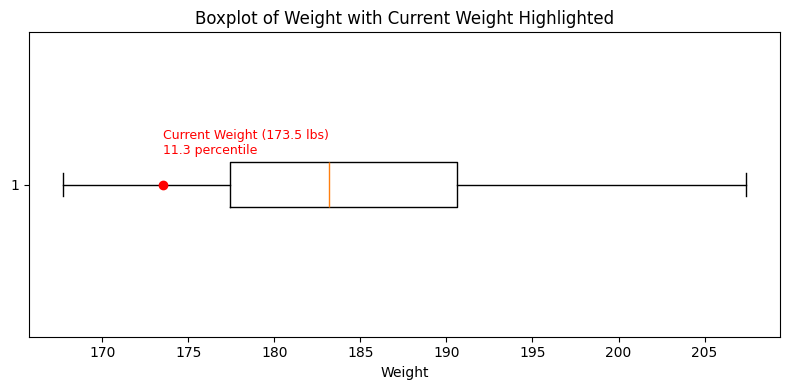

In [176]:
plot_current_weight(173.5)